Analysis of Simulation Studies
----------
Author: Albert Ulmer  
Date: 2022-06-04 - 2022-06-30

In [93]:
# autoreload packages
%load_ext autoreload
%autoreload 2

# import data & plotting libraries
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use('default')

from matplotlib import cm
import sqlite3

# import own libraries
import util
import plot
import config




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
### Set global flag whether to save plots to files or not
writefiles = 1

if writefiles:
    print("Writing output files!")
else:
    print("Leaving files alone!")


Writing output files!


In [95]:
### Set global flag whether to print debug messages while running code
showdebug = 1

if showdebug:
    print("Showing debug messages!")
else:
    print("No debug messages will be shown!")

Showing debug messages!


# Load Simulation Data


In [96]:
# connect to SQLite database
try:
    conn = sqlite3.connect('./database_gurobi/dsmdata-sim.sqlite3')
    conn_cbc = sqlite3.connect('./database_cbc/dsmdata-sim.sqlite3')
    conn_cbc_3200u = sqlite3.connect('./database_cbc_3200u/dsmdata-sim.sqlite3')

    print('Connected to database...')
except:
    print('Database error!')
    exit()

Connected to database...


In [97]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v2.sql").read()
dfps = pd.read_sql_query(queryps, conn)
dfps.pvprc = dfps.pvprc*100
dfps.bessprc = dfps.bessprc*100
dfps.SSR = dfps.SSR*100
dfps.SCR = dfps.SCR*100
if showdebug: print(dfps.tail())


                     config  model  pvprc  bessprc  period  GridDraw  \
2995  stoch_pv1.00_bess1.00  stoch  100.0    100.0      19       0.0   
2996  stoch_pv1.00_bess1.00  stoch  100.0    100.0      20       0.0   
2997  stoch_pv1.00_bess1.00  stoch  100.0    100.0      21       0.0   
2998  stoch_pv1.00_bess1.00  stoch  100.0    100.0      22       0.0   
2999  stoch_pv1.00_bess1.00  stoch  100.0    100.0      23       0.0   

      runningtime    SSR    SCR  
2995        0.593  94.52  75.98  
2996        0.862  98.22  75.41  
2997        2.060  81.07  67.69  
2998        1.096  93.91  75.71  
2999        1.836  92.17  79.72  


In [98]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v1.sql").read()
dfps_cbc = pd.read_sql_query(queryps, conn_cbc)
dfps_cbc.pvprc = dfps_cbc.pvprc*100
dfps_cbc.bessprc = dfps_cbc.bessprc*100
if showdebug: print(dfps_cbc.tail())

                     config  model  pvprc  bessprc  period      GridDraw  \
2995  stoch_pv1.00_bess1.00  stoch  100.0    100.0      19  8.578979e-01   
2996  stoch_pv1.00_bess1.00  stoch  100.0    100.0      20  0.000000e+00   
2997  stoch_pv1.00_bess1.00  stoch  100.0    100.0      21 -1.726745e-12   
2998  stoch_pv1.00_bess1.00  stoch  100.0    100.0      22  0.000000e+00   
2999  stoch_pv1.00_bess1.00  stoch  100.0    100.0      23  0.000000e+00   

      runningtime  
2995        6.123  
2996      210.306  
2997      319.950  
2998      306.520  
2999      424.954  


In [99]:
# execute SQL query
queryps = open("sqls/model_griddraw_comptime_v1.sql").read()
dfps_cbc_3200u = pd.read_sql_query(queryps, conn_cbc_3200u)
dfps_cbc_3200u.pvprc = dfps_cbc_3200u.pvprc*100
dfps_cbc_3200u.bessprc = dfps_cbc_3200u.bessprc*100
if showdebug: print(dfps_cbc_3200u.tail())

                    config  model  pvprc  bessprc  period      GridDraw  \
475  stoch_pv1.00_bess1.00  stoch  100.0    100.0      19  8.578979e-01   
476  stoch_pv1.00_bess1.00  stoch  100.0    100.0      20  0.000000e+00   
477  stoch_pv1.00_bess1.00  stoch  100.0    100.0      21 -1.726745e-12   
478  stoch_pv1.00_bess1.00  stoch  100.0    100.0      22  0.000000e+00   
479  stoch_pv1.00_bess1.00  stoch  100.0    100.0      23  0.000000e+00   

     runningtime  
475        7.917  
476      273.929  
477      400.093  
478      387.306  
479      540.916  


# Analysis

## Peakshaving

### PAPR & Standard Deviation

In [100]:
dfps_pivot = dfps.pivot_table(values="GridDraw", index=["pvprc", "bessprc"], columns="model", aggfunc=["mean", "std", "max", util.papr])
if showdebug: print(dfps_pivot.head())

                    mean                                                 std  \
model             direct   perfect      pred       rule     stoch     direct   
pvprc bessprc                                                                  
0.0   0.0       9.985679  7.239803  6.935674   9.557517  6.380580  13.187867   
      25.0      9.926774  7.185215  6.984688   9.928856  6.824040  13.400652   
      50.0     10.195326  7.503482  6.708817  10.143384  6.075857  13.753115   
      75.0     10.426733  7.647507  6.768521  10.313446  6.140306  13.867475   
      100.0    10.628929  6.959095  6.690311  10.479839  6.611492  13.806045   

                                                          max             \
model           perfect      pred       rule     stoch direct    perfect   
pvprc bessprc                                                              
0.0   0.0      2.863509  2.184120  12.816586  2.337204   35.0  12.420000   
      25.0     2.424694  2.442684  13.190774  1.733167 

In [101]:
# Translation dictionaries for plotting
model_desc = {}
model_desc["direct"] = "Direct Charging"
model_desc["rule"] = "Rule-based Charging"
model_desc["pred"] = "Predictive Charging"
model_desc["stoch"] = "Stochastic Charging"
model_desc["perfect"] = "Perfect Information"

model_abbr = {}
model_abbr["direct"] = "Direct"
model_abbr["rule"] = "Rule-based"
model_abbr["pred"] = "Predictive"
model_abbr["stoch"] = "Stochastic"
model_abbr["perfect"] = "Perfect"

metric_desc = {}
metric_desc["max"] = "Maximum Grid Draw [kW]"
metric_desc["mean"] = "Average Grid Draw [kW]"
metric_desc["papr"] = "Peak-to-Average Power Ratio"
metric_desc["std"] = "Standard Deviation"

variable_desc = {}
variable_desc["pvprc"] = "PV size [%]"
variable_desc["bessprc"] = "BESS size [%]"

In [102]:
models = ['direct', 'rule', 'pred', 'stoch', 'perfect']
metrics = ['max', 'mean', 'std', 'papr']


In [103]:
for model in models: #list(model_desc.keys()):
    for metric in metrics: #list(metric_desc.keys()):
        if showdebug: print("Working on model", model, "and metric", metric)
        label = model + "_" + metric
        my_data = np.array(dfps_pivot.loc[:,(metric)].reset_index()[["pvprc", "bessprc", model]])
        if my_data[:,2].std() == 0:
            myplot = plot.contour_plot(mydata = my_data, order = 0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        else:
            myplot = plot.contour_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        if writefiles:
            myplot.savefig("output/peakshaving_contour_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(myplot)
        #if model in  ["direct", "rule"] and metric == "max":
        if my_data[:,2].std() == 0:
            mysurf = plot.surface_plot(mydata = my_data, order = 0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        else:
            mysurf = plot.surface_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = metric_desc[metric]) #, title = model_desc[model])
        if writefiles:
            mysurf.savefig("output/peakshaving_surface_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(mysurf)

Working on model direct and metric max
Working on model direct and metric mean
Working on model direct and metric std
Working on model direct and metric papr
Working on model rule and metric max
Working on model rule and metric mean
Working on model rule and metric std
Working on model rule and metric papr
Working on model pred and metric max
Working on model pred and metric mean
Working on model pred and metric std
Working on model pred and metric papr
Working on model stoch and metric max
Working on model stoch and metric mean
Working on model stoch and metric std
Working on model stoch and metric papr
Working on model perfect and metric max
Working on model perfect and metric mean
Working on model perfect and metric std
Working on model perfect and metric papr


In [104]:
dfps_pivot.round(2)


mean                               std                       \
model         direct perfect  pred   rule stoch direct perfect  pred   rule   
pvprc bessprc                                                                 
0.0   0.0       9.99    7.24  6.94   9.56  6.38  13.19    2.86  2.18  12.82   
      25.0      9.93    7.19  6.98   9.93  6.82  13.40    2.42  2.44  13.19   
      50.0     10.20    7.50  6.71  10.14  6.08  13.75    2.34  2.14  13.33   
      75.0     10.43    7.65  6.77  10.31  6.14  13.87    2.12  1.60  13.59   
      100.0    10.63    6.96  6.69  10.48  6.61  13.81    2.58  2.02  13.62   
25.0  0.0       9.36    4.82  5.30   9.01  4.91  13.08    3.11  3.08  12.71   
      25.0      9.01    5.14  4.89   9.22  4.91  12.83    2.51  2.64  13.06   
      50.0      8.89    5.29  5.63   9.19  4.23  13.12    2.72  1.70  12.79   
      75.0      9.31    5.22  5.44   9.27  4.91  13.02    2.63  2.33  13.06   
      100.0     9.59    5.24  4.82   9.36  4.65  13.81    2.38  2.39  13.16   
50.0  0.0       8.94    3.49  3.81   8.57  3.86  12.81    2.77  3.32  12.47   
      25.0      8.30    3.33  3.49   8.50  3.62  12.50    3.18  3.04  12.59   
      50.0      8.22    3.40  3.70   8.89  3.55  12.74    3.01  3.03  12.59   
      75.0      8.70    2.99  3.66   8.56  3.15  13.06    3.16  2.60  12.55   
      100.0     7.86    3.27  4.15   8.13  3.16  13.01    2.82  2.63  12.40   
75.0  0.0       8.27    1.85  3.06   8.35  3.09  12.61    2.35  3.28  12.43   
      25.0      8.41    1.65  2.70   8.14  2.68  12.93    2.01  3.06  12.77   
      50.0      7.60    1.94  2.33   8.45  2.68  12.87    2.64  2.81  12.44   
      75.0      7.93    2.01  2.17   8.32  2.19  12.92    2.77  2.49  12.52   
      100.0     7.66    2.03  1.92   7.72  2.68  12.80    2.31  2.22  12.30   
100.0 0.0       7.49    0.74  1.83   7.63  2.37  12.61    1.53  2.35  12.51   
      25.0      7.14    0.61  1.71   8.25  1.88  12.91    1.34  2.19  12.68   
      50.0      7.30    1.00  1.74   7.87  1.55  12.67    1.76  1.99  12.49   
      75.0      7.50    0.96  1.49   7.35  1.43  12.73    1.49  1.95  12.37   
      100.0     7.43    1.01  1.41   7.77  1.05  12.67    1.68  1.88  12.38   

                       max                               papr                \
model         stoch direct perfect   pred  rule  stoch direct perfect  pred   
pvprc bessprc                                                                 
0.0   0.0      2.34   35.0   12.42  12.42  35.0  12.35   3.51    1.72  1.79   
      25.0     1.73   35.0   13.42  12.42  35.0   9.89   3.53    1.87  1.78   
      50.0     2.43   35.0   12.42   9.28  35.0  10.41   3.43    1.66  1.38   
      75.0     2.47   35.0   12.42   9.28  35.0  10.21   3.36    1.62  1.37   
      100.0    2.03   35.0    9.84  12.42  35.0  11.62   3.29    1.41  1.86   
25.0  0.0      2.81   35.0    8.98   8.28  35.0   8.68   3.74    1.86  1.56   
      25.0     2.54   35.0    8.28   8.28  35.0   9.83   3.88    1.61  1.69   
      50.0     2.92   35.0    9.61   8.28  35.0   9.70   3.94    1.82  1.47   
      75.0     2.60   35.0    8.28   9.41  35.0   9.03   3.76    1.58  1.73   
      100.0    2.66   35.0    8.28  10.15  35.0   8.67   3.65    1.58  2.11   
50.0  0.0      2.40   35.0    8.28   8.28  35.0   8.28   3.91    2.37  2.17   
      25.0     2.74   35.0    9.02   9.21  35.0   8.28   4.22    2.71  2.64   
      50.0     2.68   35.0    8.28   8.40  35.0   9.07   4.26    2.43  2.27   
      75.0     2.55   35.0    8.28   8.62  35.0   8.28   4.02    2.77  2.35   
      100.0    2.60   35.0    8.28   8.28  35.0   8.28   4.45    2.53  1.99   
75.0  0.0      2.49   35.0    6.65   8.28  35.0   7.67   4.23    3.58  2.71   
      25.0     2.21   35.0    4.89   8.83  35.0   6.23   4.16    2.96  3.28   
      50.0     2.33   35.0    7.64   8.28  35.0   8.28   4.61    3.93  3.55   
      75.0     2.43   35.0    8.28   8.28  35.0   6.22   4.42    4.13  3.82   
      100.0    2.28   35.0    7.92   5.46  35.0   8.12   4.57    

In [105]:
dfps_pivot_pretty = dfps_pivot.round(2).copy()
dfps_pivot_pretty.index.names = ["PV %", "BESS %"]
dfps_pivot_pretty.columns.set_levels(["Average", "Std. Dev.", "Maximum", "PAPR"], level=0, inplace=True)
dfps_pivot_pretty.columns.set_levels(["Direct", "Perfect", "Predictive", "Rule-based", "Stochastic"], level=1, inplace=True)
#dfps_pivot_pretty.to_latex(buf="output/peakshaving_results.tex", bold_rows=True)
if writefiles:
    dfps_pivot_pretty.loc[:, ["Maximum", "Average"]].to_latex(
        buf="output/peakshaving_results1.tex", bold_rows=True)
    dfps_pivot_pretty.loc[:, ["Std. Dev.", "PAPR"]].to_latex(
        buf="output/peakshaving_results2.tex", bold_rows=True)


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\2686266419.py:3: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfps_pivot_pretty.columns.set_levels(["Average", "Std. Dev.", "Maximum", "PAPR"], level=0, inplace=True)
C:\Users\alber\AppData\Local\Temp\ipykernel_12088\2686266419.py:4: FutureWarning: inplace is deprecated and will be removed in a future version.
  dfps_pivot_pretty.columns.set_levels(["Direct", "Perfect", "Predictive", "Rule-based", "Stochastic"], level=1, inplace=True)
C:\Users\alber\AppData\Local\Temp\ipykernel_12088\2686266419.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot_pretty.loc[:, ["Maximum", "Average"]].to_latex(
C:\Users\alber\AppData\Local\Temp\ipykernel

In [106]:
list(model_abbr.keys())


['direct', 'rule', 'pred', 'stoch', 'perfect']

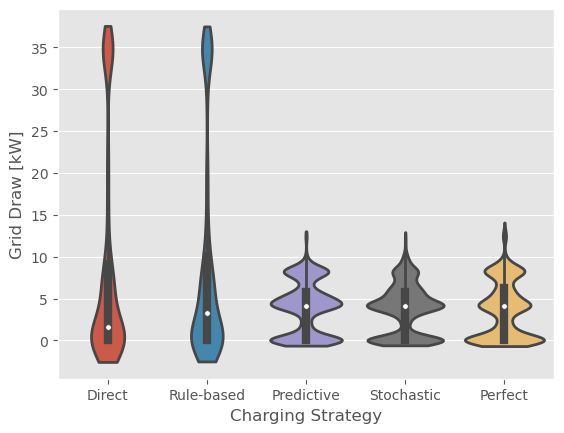

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps, x="model", y="GridDraw", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Grid Draw [kW]")
ax.set_xticklabels(list(model_abbr.values()))

if writefiles:
    plt.savefig("output/GridDraw_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()

## Computation Time

### Gurobi

In [108]:
dfrt_pivot = dfps.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"]).round(3)
if showdebug: print(dfrt_pivot.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct        0.094       0.031       0.225
perfect       0.096       0.035       0.407
pred          0.084       0.017       0.210
rule          0.112       0.026       0.255
stoch         1.775       1.912      39.710


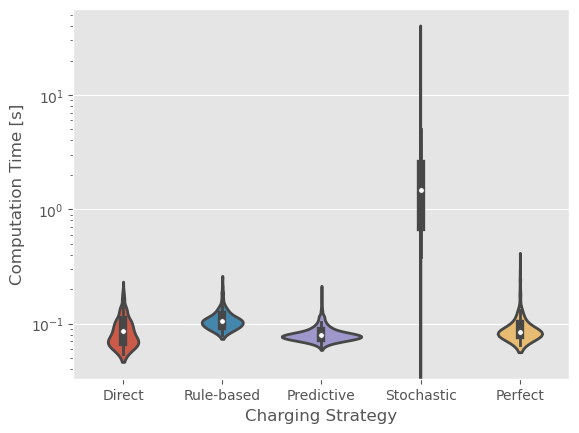

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# models = ["Direct", "Rule-based", "Predictive", "Stochastic", "Perfect"]

f, ax = plt.subplots()
sns.violinplot(data=dfps, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.25, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### CBC


In [110]:
dfrt_pivot_cbc = dfps_cbc.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"]).round(3)
if showdebug: print(dfrt_pivot_cbc.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct        0.803       0.560       3.425
perfect       1.160       0.455       3.051
pred          0.987       0.418       3.623
rule          1.078       8.005     192.697
stoch       319.005     219.651    1803.512


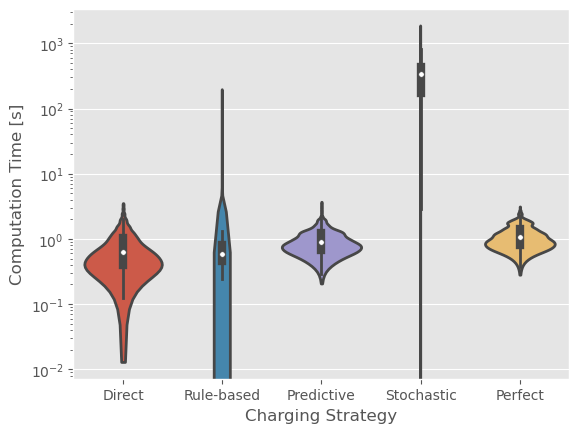

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps_cbc, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin_cbc.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


### CBC on Ryzen 3 3200U

In [112]:
dfrt_pivot_cbc_3200u = dfps_cbc_3200u.pivot_table(values="runningtime",  index="model", aggfunc=["mean", "std", "max"]).round(3)
if showdebug: print(dfrt_pivot_cbc_3200u.head())

               mean         std         max
        runningtime runningtime runningtime
model                                      
direct        0.782       0.716       2.982
perfect       1.235       0.737       3.864
pred          1.211       0.984       5.982
rule          1.404       6.465      63.909
stoch       229.478     281.612    1568.841


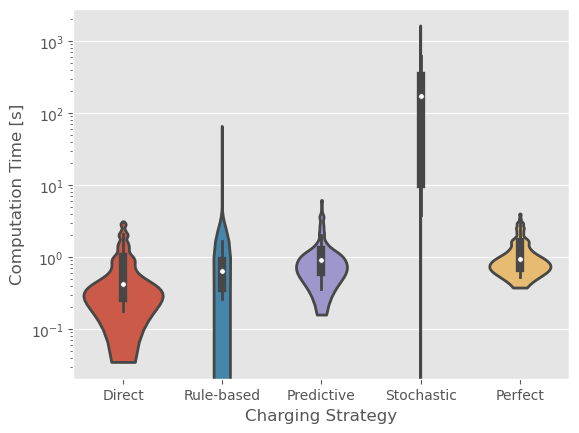

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfps_cbc_3200u, x="model", y="runningtime", order=list(model_abbr.keys()),
               alpha=1, bw=.2, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Computation Time [s]")
ax.set_xticklabels(list(model_abbr.values()))
ax.set_yscale("log")

if writefiles:
    plt.savefig("output/runningtime_violin_cbc_3200u.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


In [114]:
dfrt_pivot.merge(dfrt_pivot_cbc, left_index=True, right_index=True, suffixes=["_i7-Gurobi", "_i7-CBC"]).round(3)

,mean_i7-Gurobi,std_i7-Gurobi,max_i7-Gurobi,mean_i7-CBC,std_i7-CBC,max_i7-CBC
,runningtime,runningtime,runningtime,runningtime,runningtime,runningtime
model,,,,,,
direct,0.094,0.031,0.225,0.803,0.560,3.425
perfect,0.096,0.035,0.407,1.160,0.455,3.051
pred,0.084,0.017,0.210,0.987,0.418,3.623
rule,0.112,0.026,0.255,1.078,8.005,192.697
stoch,1.775,1.912,39.710,319.005,219.651,1803.512


In [115]:
dfps["env"] = "Gurobi on i7"
dfps_cbc["env"] = "CBC on i7"
dfps_cbc_3200u["env"] = "CBC on 3200U"

dfrt_all = pd.concat([dfps, dfps_cbc, dfps_cbc_3200u])
dfrt_all

dfrt_pivot_all = dfrt_all.pivot_table(values="runningtime",  index="model", columns=["env"], aggfunc=["mean", "std", "max"]).round(3)
dfrt_pivot_all.columns.names = ["Metric", "CPU"]
dfrt_pivot_all.index = list(model_abbr.values())
dfrt_pivot_all.index.name = "strategy"
if showdebug: print(dfrt_pivot_all.head())

Metric             mean                                 std            \
CPU        CBC on 3200U CBC on i7 Gurobi on i7 CBC on 3200U CBC on i7   
strategy                                                                
Direct            0.782     0.803        0.094        0.716     0.560   
Rule-based        1.235     1.160        0.096        0.737     0.455   
Predictive        1.211     0.987        0.084        0.984     0.418   
Stochastic        1.404     1.078        0.112        6.465     8.005   
Perfect         229.478   319.005        1.775      281.612   219.651   

Metric                           max                         
CPU        Gurobi on i7 CBC on 3200U CBC on i7 Gurobi on i7  
strategy                                                     
Direct            0.031        2.982     3.425        0.225  
Rule-based        0.035        3.864     3.051        0.407  
Predictive        0.017        5.982     3.623        0.210  
Stochastic        0.026       63.909   192.

In [116]:
if writefiles:
    dfrt_pivot_all.to_latex(buf="output/comptime_results.tex", bold_rows=True)

C:\Users\alber\AppData\Local\Temp\ipykernel_12088\1840639952.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfrt_pivot_all.to_latex(buf="output/comptime_results.tex", bold_rows=True)


## Charging Comfort


In [117]:
# execute SQL query
querycc = open("sqls/model_charging_comfort_v2.sql").read()
dfcc = pd.read_sql_query(querycc, conn)
dfcc.pvprc = dfcc.pvprc * 100
dfcc.bessprc = dfcc.bessprc * 100
if showdebug:
    print(dfcc.head())


                   config   model  pvprc  bessprc      EVSOC
0  direct_pv0.00_bess0.00  direct    0.0      0.0  36.369045
1  direct_pv0.00_bess0.25  direct    0.0     25.0  36.214366
2  direct_pv0.00_bess0.50  direct    0.0     50.0  36.038748
3  direct_pv0.00_bess0.75  direct    0.0     75.0  36.072837
4  direct_pv0.00_bess1.00  direct    0.0    100.0  36.072837


In [118]:
c0 = config.varpvbess_1()
c0["E_EV_MAX"]
#dfcc['SOCperc']=round(dfcc.EVSOC/c0["E_EV_MAX"],2)
dfcc['SOCperc']=round(100*dfcc.EVSOC/c0["E_EV_MAX"],0)
dfcc[dfcc.model == "stoch"]

,config,model,pvprc,bessprc,EVSOC,SOCperc
100,stoch_pv0.00_bess0.00,stoch,0.0,0.0,27.629617,73.0
101,stoch_pv0.00_bess0.25,stoch,0.0,25.0,28.053938,74.0
102,stoch_pv0.00_bess0.50,stoch,0.0,50.0,26.696589,70.0
103,stoch_pv0.00_bess0.75,stoch,0.0,75.0,26.608736,70.0
104,stoch_pv0.00_bess1.00,stoch,0.0,100.0,27.455459,72.0
105,stoch_pv0.25_bess0.00,stoch,25.0,0.0,29.372331,77.0
106,stoch_pv0.25_bess0.25,stoch,25.0,25.0,29.044550,76.0
107,stoch_pv0.25_bess0.50,stoch,25.0,50.0,28.464319,75.0
108,stoch_pv0.25_bess0.75,stoch,25.0,75.0,28.260149,74.0
109,stoch_pv0.25_bess1.00,stoch,25.0,100.0,29.896463,79.0


In [119]:
models

['direct', 'rule', 'pred', 'stoch', 'perfect']

In [120]:
np.array(dfcc.loc[dfcc.model == "stoch"].reset_index()[["pvprc", "bessprc", "SOCperc"]])

array([[  0.,   0.,  73.],
       [  0.,  25.,  74.],
       [  0.,  50.,  70.],
       [  0.,  75.,  70.],
       [  0., 100.,  72.],
       [ 25.,   0.,  77.],
       [ 25.,  25.,  76.],
       [ 25.,  50.,  75.],
       [ 25.,  75.,  74.],
       [ 25., 100.,  79.],
       [ 50.,   0.,  77.],
       [ 50.,  25.,  79.],
       [ 50.,  50.,  73.],
       [ 50.,  75.,  77.],
       [ 50., 100.,  77.],
       [ 75.,   0.,  74.],
       [ 75.,  25.,  79.],
       [ 75.,  50.,  77.],
       [ 75.,  75.,  78.],
       [ 75., 100.,  76.],
       [100.,   0.,  76.],
       [100.,  25.,  76.],
       [100.,  50.,  79.],
       [100.,  75.,  76.],
       [100., 100.,  75.]])

In [121]:
for model in models: #list(model_desc.keys()):
    if showdebug: print("Working on model", model)
    label = model
    my_data = np.array(dfcc.loc[dfcc.model == model].reset_index()[["pvprc", "bessprc", "SOCperc"]])
    myplot = plot.contour_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = "Satisfaction [%]", color="green") #, title = model_desc[model])
    if writefiles:
        myplot.savefig("output/chargingcomfort_contour_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(myplot)
    mysurf = plot.surface_plot(mydata = my_data, order = 2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel = "Satisfaction [%]", color="green") #, title = model_desc[model])
    if writefiles:
        mysurf.savefig("output/chargingcomfort_surface_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(mysurf)

Working on model direct
Working on model rule
Working on model pred
Working on model stoch
Working on model perfect


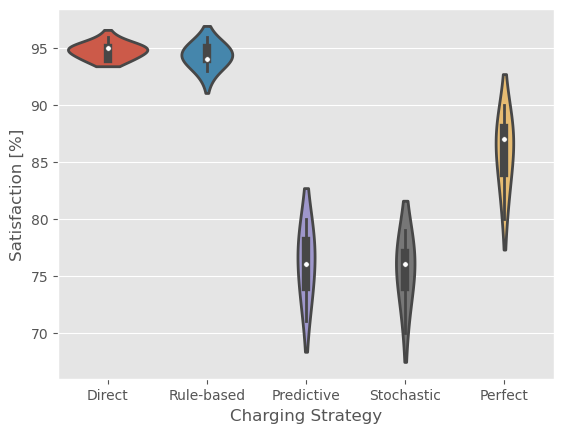

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

f, ax = plt.subplots()
sns.violinplot(data=dfcc, x="model", y="SOCperc", order=list(model_abbr.keys()),
               alpha=1, bw=1, cut=1, linewidth=2)
ax.set_xlabel("Charging Strategy")
ax.set_ylabel("Satisfaction [%]")
ax.set_xticklabels(list(model_abbr.values()))

if writefiles:
    plt.savefig("output/chargingcomfort_violin.png",
                bbox_inches='tight', dpi=300)
    #plt.close()


## SSR & SCR

In [123]:
dfps.loc[(dfps.pvprc > 0) & (dfps.period == 0)]

,config,model,pvprc,bessprc,period,GridDraw,runningtime,SSR,SCR,env
120,direct_pv0.25_bess0.00,direct,25.0,0.0,0,35.000000,0.201,8.24,51.42,Gurobi on i7
144,direct_pv0.25_bess0.25,direct,25.0,25.0,0,35.000000,0.126,14.73,90.34,Gurobi on i7
168,direct_pv0.25_bess0.50,direct,25.0,50.0,0,35.000000,0.195,14.78,90.68,Gurobi on i7
192,direct_pv0.25_bess0.75,direct,25.0,75.0,0,35.000000,0.142,14.01,85.98,Gurobi on i7
216,direct_pv0.25_bess1.00,direct,25.0,100.0,0,35.000000,0.182,13.93,84.90,Gurobi on i7
...,...,...,...,...,...,...,...,...,...,...
2880,stoch_pv1.00_bess0.00,stoch,100.0,0.0,0,5.544549,0.632,58.17,98.70,Gurobi on i7
2904,stoch_pv1.00_bess0.25,stoch,100.0,25.0,0,4.590602,0.939,58.26,98.88,Gurobi on i7
2928,stoch_pv1.00_bess0.50,stoch,100.0,50.0,0,4.484244,0.567,57.29,98.65,Gurobi on i7
2952,stoch_pv1.00_bess0.75,stoch,100.0,75.0,0,4.953917,0.682,57.06,98.44,Gurobi on i7


In [124]:
pvmetrics = ["SSR", "SCR"]

pvmetric_desc = {}
pvmetric_desc["SSR"] = "Self-sufficiency Rate [%]"
pvmetric_desc["SCR"] = "Self-consumption Rate [%]"


In [125]:
np.array(dfps.loc[dfps["model"] == "stoch"].reset_index()[["pvprc", "bessprc", "SSR"]])

array([[  0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   0.  ],
       ...,
       [100.  , 100.  ,  81.07],
       [100.  , 100.  ,  93.91],
       [100.  , 100.  ,  92.17]])

In [126]:
for model in models:  # list(model_desc.keys()):
    for metric in pvmetrics:  # list(metric_desc.keys()):
        if showdebug:
            print("Working on model", model, "and metric", metric)
        label = model + "_" + metric
        my_data = np.array(dfps.loc[(dfps["model"] == model) & (dfps.period == 0) & (dfps.pvprc > 0)].reset_index()[["pvprc", "bessprc", metric]])

        if my_data[:, 2].std() == 0:
            #myplot = plot.contour_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            myplot = plot.contour_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        else:
            #myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            myplot = plot.contour_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        if writefiles:
            myplot.savefig("output/pvmetric_contour_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(myplot)
        if my_data[:, 2].std() == 0:
            #mysurf = plot.surface_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            mysurf = plot.surface_plot(mydata=my_data, order=0, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        else:
            #mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], title=model_desc[model], color="yellow")
            mysurf = plot.surface_plot(mydata=my_data, order=2, xlabel=variable_desc["pvprc"], ylabel=variable_desc["bessprc"], zlabel=pvmetric_desc[metric], color="yellow")
        if writefiles:
            mysurf.savefig("output/pvmetric_surface_"+label+".png",
                           bbox_inches='tight', dpi=300)
            plt.close(mysurf)


Working on model direct and metric SSR
Working on model direct and metric SCR
Working on model rule and metric SSR
Working on model rule and metric SCR
Working on model pred and metric SSR
Working on model pred and metric SCR
Working on model stoch and metric SSR
Working on model stoch and metric SCR
Working on model perfect and metric SSR
Working on model perfect and metric SCR


## Summary

In [127]:
# label the configurations
dfps["config"] = "other"
dfps.loc[(dfps.pvprc == 0) & (dfps.bessprc == 0), "config"] = "LVG only"
dfps.loc[(dfps.pvprc == 100) & (dfps.bessprc == 0), "config"] = "LVG + PV"
dfps.loc[(dfps.pvprc == 0) & (dfps.bessprc == 100), "config"] = "LVG + BESS"
dfps.loc[(dfps.pvprc == 100) & (dfps.bessprc == 100), "config"] = "LVG + PV + BESS"
for model in dfps.model.unique():
    try:
        dfps.loc[(dfps.model == model), "model"] = model_abbr[model]
    except:
        pass
dfps

,config,model,pvprc,bessprc,period,GridDraw,runningtime,SSR,SCR,env
0,LVG only,Direct,0.0,0.0,0,35.000000,0.092,0.00,0.00,Gurobi on i7
1,LVG only,Direct,0.0,0.0,1,35.000000,0.085,0.00,0.00,Gurobi on i7
2,LVG only,Direct,0.0,0.0,2,35.000000,0.090,0.00,0.00,Gurobi on i7
3,LVG only,Direct,0.0,0.0,3,35.000000,0.075,0.00,0.00,Gurobi on i7
4,LVG only,Direct,0.0,0.0,4,22.566137,0.069,0.00,0.00,Gurobi on i7
...,...,...,...,...,...,...,...,...,...,...
2995,LVG + PV + BESS,Stochastic,100.0,100.0,19,0.000000,0.593,94.52,75.98,Gurobi on i7
2996,LVG + PV + BESS,Stochastic,100.0,100.0,20,0.000000,0.862,98.22,75.41,Gurobi on i7
2997,LVG + PV + BESS,Stochastic,100.0,100.0,21,0.000000,2.060,81.07,67.69,Gurobi on i7
2998,LVG + PV + BESS,Stochastic,100.0,100.0,22,0.000000,1.096,93.91,75.71,Gurobi on i7


In [137]:
dfps_pivot2 = dfps[dfps.config != "other"].pivot_table(values="GridDraw", columns=["config"], index=["model"], aggfunc=["max", "mean", "std", util.papr])
dfps_pivot2.columns.names = ["Metric", "Configuration"]
#dfps_pivot2.index = list(model_abbr.values())
dfps_pivot2.index.name = "Strategy"
if showdebug: print(dfps_pivot2.head())

Metric               max                                             mean  \
Configuration LVG + BESS   LVG + PV LVG + PV + BESS   LVG only LVG + BESS   
Strategy                                                                    
Direct         35.000000  35.000000           35.00  35.000000  10.628929   
Perfect         9.837942   4.140000            4.14  12.420000   6.959095   
Predictive     12.420000   8.139675            4.14  12.420000   6.690311   
Rule-based     35.000000  35.000000           35.00  35.000000  10.479839   
Stochastic     11.624194   7.333725            5.14  12.351338   6.611492   

Metric                                                   std             \
Configuration  LVG + PV LVG + PV + BESS  LVG only LVG + BESS   LVG + PV   
Strategy                                                                  
Direct         7.494389        7.428391  9.985679  13.806045  12.605466   
Perfect        0.739176        1.010902  7.239803   2.581088   1.528504   
Predicti

In [138]:
#models = ['direct', 'rule', 'pred', 'stoch', 'perfect']
models2 = list(model_abbr.values())
models2.reverse()
metrics2 = list(model_abbr.keys()) #['max', 'mean', 'std', 'papr']
configs = ["LVG only", "LVG + PV", "LVG + BESS", "LVG + PV + BESS"]



In [139]:
dfps_pivot2["mean"].loc[models2,configs].round(2)

Configuration,LVG only,LVG + PV,LVG + BESS,LVG + PV + BESS
Strategy,,,,
Perfect,7.24,0.74,6.96,1.01
Stochastic,6.38,2.37,6.61,1.05
Predictive,6.94,1.83,6.69,1.41
Rule-based,9.56,7.63,10.48,7.77
Direct,9.99,7.49,10.63,7.43


In [140]:
# from mpl_toolkits.mplot3d import Axes3D
for metric in metrics:  # list(metric_desc.keys()):
    if showdebug:
        print("Working on metric", metric)
    label = metric
    plt.style.use("default")
    mybar3d = plot.bar3d_plot(dfps_pivot2[metric].loc[models2, configs], xlabel="Configuration", ylabel="Model", zlabel=metric_desc[metric], color="rainbow")
    if writefiles:
        mybar3d.savefig("output/model_summary_bar3d_"+label+".png",
                        bbox_inches='tight', dpi=300)
        plt.close(mybar3d)
        dfps_pivot2[metric].loc[list(model_abbr.values()), configs].round(2).to_latex(
            buf="output/model_summary_table_"+label+".tex", bold_rows=True)



Working on metric max


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\3080090807.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot2[metric].loc[list(model_abbr.values()), configs].round(2).to_latex(


Working on metric mean


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\3080090807.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot2[metric].loc[list(model_abbr.values()), configs].round(2).to_latex(


Working on metric std


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\3080090807.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot2[metric].loc[list(model_abbr.values()), configs].round(2).to_latex(


Working on metric papr


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\3080090807.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot2[metric].loc[list(model_abbr.values()), configs].round(2).to_latex(


In [141]:
dfps_pivot2["max"].loc[models2[0:3],configs].mean(axis=1)


Strategy
Perfect       7.634486
Stochastic    9.112314
Predictive    9.279919
dtype: float64

In [142]:
dfps_pivot3 = dfps_pivot2["max"].loc[models2[0:3],configs].round(2).median(axis=1).round(2)
#dfps_pivot3["Average"] = dfps_pivot3.median(axis=1).round(2)
dfps_pivot3 = pd.DataFrame(dfps_pivot3)
dfps_pivot3.columns = ["Average"]
dfps_pivot3

,Average
Strategy,
Perfect,6.99
Stochastic,9.48
Predictive,10.28


In [143]:
models3 = list(model_abbr.values())[2:]
models3


['Predictive', 'Stochastic', 'Perfect']

In [144]:
dfps_pivot4 = pd.DataFrame(dfps_pivot3.loc[models3, "Average"]).T
dfps_pivot4["VSS"] = -1 * (dfps_pivot4["Stochastic"] - dfps_pivot4["Predictive"])
dfps_pivot4["EVPI"] = -1 * (dfps_pivot4["Perfect"] - dfps_pivot4["Stochastic"])
dfps_pivot4.index = ["Grid Draw Maximum [kW]"]
dfps_pivot4


Strategy,Predictive,Stochastic,Perfect,VSS,EVPI
Grid Draw Maximum [kW],10.28,9.48,6.99,0.8,2.49


In [145]:
if writefiles:
    dfps_pivot4.to_latex(
        buf="output/model_summary_vss_evpi.tex", bold_rows=True)


C:\Users\alber\AppData\Local\Temp\ipykernel_12088\420681063.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dfps_pivot4.to_latex(
